In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime
from datetime import date

#### Paths

In [89]:
root_dir=os.path.join('x:/Marphys_Archive','Data','OSNAP','RHADCP','RHADCP_S55_data_JC238','S200044A008_RHADCP_2020')

## inpaths
HEADER_FILE='S200044A008_RHADCP_2020_A0.whr'
HEADER_FILE_PATH=os.path.join(root_dir,HEADER_FILE)

DATA_FILE='S200044A008_RHADCP_2020_A0_p.dat'
DATA_FILE_PATH=os.path.join(root_dir,DATA_FILE)

## outpaths
HEADER_LINES=os.path.join(root_dir,"header.txt")

OUTFILE=os.path.join(root_dir,"RHADCP_S55_data_JC238.nc")

### Read header file and print output

In [3]:
#  extract the header data
with open(HEADER_FILE_PATH) as HEADER_FILE_PATH:
    for line in HEADER_FILE_PATH:
        print(line.rstrip())

[X:\Marphys_Archive\Data\OSNAP\RHADCP\RHADCP_S55_data_JC238\S200044A008_RHADCP_2020\S200044A008_RHADCP_2020_A0.prf]
---------------------------------------------------------------------
Number of measurements                30863
Number of checksum errors             0
Time of first measurement             15/10/2020 11:30:01.001
Time of last measurement              20/07/2022 10:30:55.001

Hardware configuration
---------------------------------------------------------------------
Instrument name                       Signature55
Serial number                         200044
Head frequency                        55 kHz
Firmware version                      169.2211_4
Pressure sensor                       YES
Compass                               YES
Tilt sensor                           YES
Temperature sensor                    YES
Number of head beams                  3

Deployment configuration
---------------------------------------------------------------------
Sound speed        

#### Extract the header from each ensemble period

In [4]:
with open(DATA_FILE_PATH) as f:
    lines = f.readlines()
desired_lines = lines[0:1759135:57]

#### Print to file then read again but this time concatenate the times

In [5]:
with open(HEADER_LINES, "w") as f:
    f.writelines(desired_lines)
    

#### Extract timestamp and other array type variables *Month Day Year Hour Minute Second*

In [6]:
timestamp=[]
pitch=[]
roll=[]
heading=[]
pressure=[]
temperature=[]

with open(HEADER_LINES) as f:
    lines = f.readlines()       
    for x in lines:
            y=int(x.split()[2])
            m=int(x.split()[0])
            d=int(x.split()[1])
            h=int(x.split()[3])
            mn=int(x.split()[4])
            s=int(x.split()[5])
            d=datetime.datetime(y,m,d,h,mn,s)
            time=d.isoformat()
            timestamp.append(time)
            #heading
            h=float(x.split()[10])
            heading.append(h)            
            # pitch
            p=int(float(x.split()[11]))
            pitch.append(p)
            # roll
            r=int(float(x.split()[12]))
            roll.append(r)
            # temperature
            t=float(x.split()[14])
            temperature.append(t)
            # pressure
            P=int(float(x.split()[13]))
            pressure.append(P)           
            
            
time = np.array(timestamp, dtype='datetime64')
pressure=np.array(pressure,dtype='int64')
heading=np.array(heading,dtype='int64')
pitch=np.array(pitch,dtype='int64')
roll=np.array(roll,dtype='int64')
temperature=np.array(temperature,dtype='int64')

### Quick plot of the variables to check everyting is OK

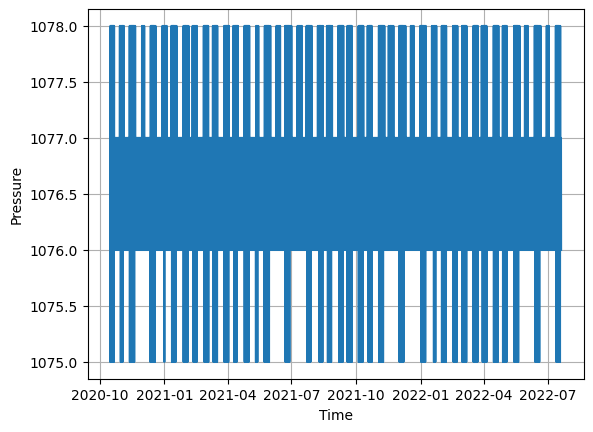

In [7]:
plt.plot(time[20:-10],pressure[20:-10])
plt.ylabel('Pressure')
plt.xlabel('Time')
plt.grid()

#### Extract sample data, store in bin by time array and save as float32

In [69]:
with open(DATA_FILE_PATH) as f:
    lines = f.readlines()
    
start=1
stop=1
while stop<1759191:
    stop=start+56
    templines=lines[start:stop]
    start=stop+1
    templines
    if start==58:
        # get bin number coordinate
        bin=[]
        for x in templines:
            bin.append(x.split()[0])
        bin_num=np.array([int(x) for x in bin])
        
        # get first velocity measurement
        cellpos=[]
        vele=[]
        veln=[]
        velu=[]
        for x in templines:
            cellpos.append(x.split()[1])
            vele.append(x.split()[2])
            veln.append(x.split()[3])
            velu.append(x.split()[4])
        cell_position=np.array([int(float(x)) for x in cellpos])
        vel_east=np.array([int(float(x)) for x in vele])
        vel_north=np.array([int(float(x)) for x in veln])
        vel_up=np.array([int(float(x)) for x in velu])
    else:
        cellpos=[]
        vele=[]
        veln=[]
        velu=[]
        for x in templines:
            cellpos.append(x.split()[1])
            vele.append(x.split()[2])
            veln.append(x.split()[3])
            velu.append(x.split()[4])
        cell_pos=np.array([x for x in cell_pos],dtype=np.float32)  
        velex=np.array([x for x in vele],dtype=np.float32)  
        velnx=np.array([x for x in veln],dtype=np.float32)        
        velux=np.array([x for x in velu],dtype=np.float32)       
        cell_position=np.c_[ cell_position, cell_pos ]          
        vel_east=np.c_[ vel_east, velex ]          
        vel_north=np.c_[ vel_north, velnx ]          
        vel_up=np.c_[ vel_up, velux ]  

In [70]:
#  create dataset using OCEANsites format
ds = xr.Dataset(
    {"velocity_east": (("BIN", "TIME"), vel_east,
                        {'units':'m s-1','description':'eastward_sea_water_velocity'}),
        "velocity_north": (("bin", "TIME"), vel_north,
                        {'units':'m/s','description':'northward_sea_water_velocity'}),
        "velocity_up": (("BIN", "TIME"), vel_up,
                        {'units':'m/s','description':'Velocity (Beam3|Z|Up)'}),        
         "cell_position": (("BIN", "TIME"), cell_position,
                        {'units':'m','description':'Cell position'}),
        "temperature": (( "time"), temperature,
                        {'units':'degrees Celsius','description':'temperature at sensor head'}),
        "pressure": (( "TIME"), pressure,{'units':'decibars'}),
        "heading": (( "TIME"), heading, {'units':'degrees'}),
        "pitch": (( "TIME"), pitch,{'units':'degrees'}),
        "roll": (( "TIME"), roll,{'units':'degrees'})
    },
    coords={
        "BIN": bin_num,
        "TIME": time,
    },
  attrs={"principal_investigator": "Stuart Cunningham",
          "principal_investigator_email": "stuart.cunningham@sams.ac.uk",
          "principal_investigator_url": "http://www.sams.ac.uk",
          "institution": "Scottish Association for Marine Science, SAMS",
          "contributor_name": "Lewis Drysdale",
          "contributor_role": "data processing and interpretation",
          "contributor_email": "lewis.drysdale@sams.ac.uk",
          "project": "OSNAP",
          "history": "Delayed time processed quality controlled",
          "processing_level":"calibrated;good data",
          "sensor_manufacturer": "Nortek",
          "sensor_model": "Signature 55",
          "sens_orientation": "upward",
          "sensor_mount": "mounted_on_seafloor_structure ",
          "coordsyst": "East-North-Up"},
)

C:\Users\sa01ld\AppData\Local\Temp\ipykernel_17920\1574464535.py:2: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = xr.Dataset(


In [71]:
ds

<xarray.Dataset>
Dimensions:         (BIN: 56, TIME: 30863, bin: 56, time: 30863)
Coordinates:
  * BIN             (BIN) int32 1 2 3 4 5 6 7 8 9 ... 48 49 50 51 52 53 54 55 56
  * TIME            (TIME) datetime64[ns] 2020-10-15T11:30:01 ... 2022-07-20T...
Dimensions without coordinates: bin, time
Data variables:
    velocity_east   (BIN, TIME) float64 -9.0 -9.0 -9.0 -9.0 ... -9.0 -9.0 0.0
    velocity_north  (bin, TIME) float64 -9.0 -9.0 -9.0 -9.0 ... -9.0 -9.0 0.0
    velocity_up     (BIN, TIME) float64 -9.0 -9.0 -9.0 -9.0 ... -9.0 -9.0 0.0
    cell_position   (BIN, TIME) float64 21.0 21.9 21.9 ... 1.122e+03 1.122e+03
    temperature     (time) int64 14 14 15 15 14 14 14 14 14 ... 5 5 5 5 5 5 9 12
    pressure        (TIME) int64 0 0 0 0 0 0 0 ... 1076 1077 1077 1077 306 0
    heading         (TIME) int64 91 97 150 137 146 120 ... 328 328 329 21 300
    pitch           (TIME) int64 -23 -26 -85 -86 -86 -85 ... -1 -1 -1 0 0 -15
    roll            (TIME) int64 -45 -41 12 16 8 21 14 16 ... 0 1 1 0 0 0 12 -77
Attributes: (12/15)
    principal_investigator:        Stuart Cunningham
    principal_investigator_email:  stuart.cunningham@sams.ac.uk
    principal_investigator_url:    http://www.sams.ac.uk
    institution:                   Scottish Association for Marine Science, SAMS
    contributor_name:              Lewis Drysdale
    contributor_role:              data processing and interpretation
    ...                            ...
    processing_level:              calibrated;good data
    sensor_manufacturer:           Nortek
    sensor_model:                  Signature 55
    sens_orientation:              upward
    sensor_mount:                  mounted_on_seafloor_structure 
    coordsyst:                     East-North-Up

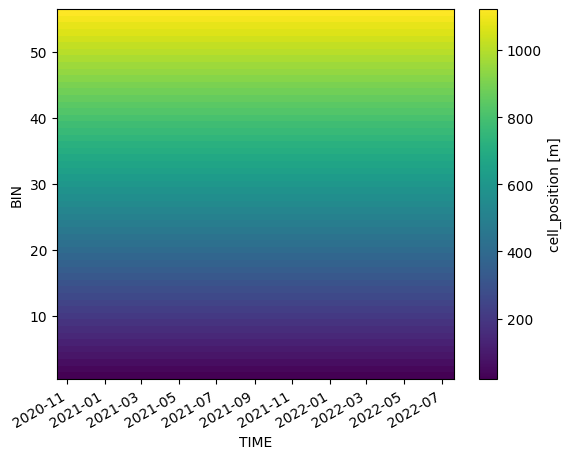

In [92]:
ds.cell_position.plot()

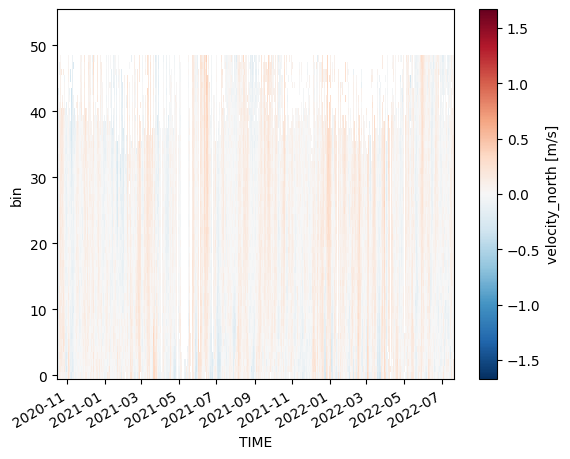

In [88]:
ds.velocity_north.where(ds.velocity_north != -9).plot()

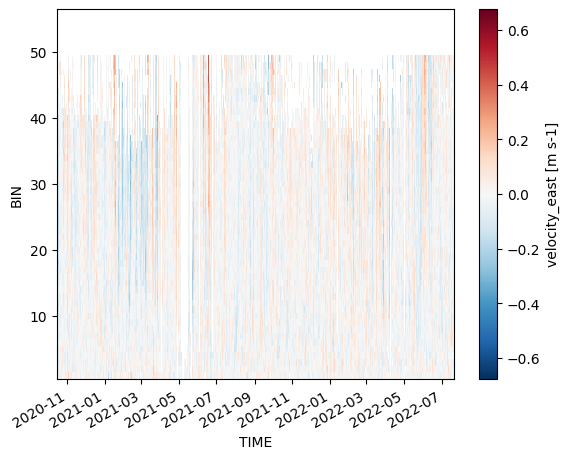

In [91]:
ds.velocity_east.where(ds.velocity_east != -9).plot()

In [90]:
ds.to_netcdf(OUTFILE)